In [1]:
import torch

torch.manual_seed(42)

device_id = 2
using = 0.4
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# torch.cuda.set_per_process_memory_fraction(using, device_id)
# # GPU 메모리 사용 비율 설정
# torch.cuda.empty_cache()
# # GPU 캐시 비우기
# # 총 메모리 용량 계산
# total_memory = torch.cuda.get_device_properties(device_id).total_memory
# # GPU 메모리의 49.9% 사용
# tmp_tensor = torch.empty(int(total_memory * (using-0.001)), dtype=torch.int8, device=device)
# print(f'use:{tmp_tensor}')

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import WeightedRandomSampler

In [2]:
from LoadData import load_data, train_model

In [3]:
dataloaders_dict = load_data()

3379
Class: A, Count: 1401
Class: B, Count: 739
Class: C, Count: 695
Class: F, Count: 544
846
Class: A, Count: 351
Class: B, Count: 185
Class: C, Count: 175
Class: F, Count: 135


In [4]:
len(dataloaders_dict['train'])*8, len(dataloaders_dict['val'])*8

(3384, 848)

A  A  A  C  B  F  F  A


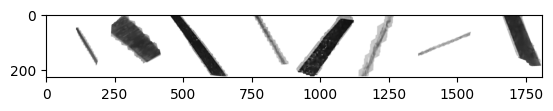

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 인라인 이미지 표시를 위한 헬퍼 함수
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ('A', 'B', 'C', 'F')
        
dataiter = iter(dataloaders_dict['train'])
images, labels = next(dataiter)

# 이미지를 격자로 생성하고 표시
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(8)))

In [6]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [7]:
# def train_model(net , dataloaders_dict, criterion, optimizer, num_epochs, save_model='model.pth'):
#     # 에폭
#     result = {'train loss':[], 'val loss':[], 'train acc':[], 'val acc':[]}
#     max_acc = 0.0
#     for epoch in range(num_epochs): 
#         print(f'Epoch {epoch + 1}/ {num_epochs}')
#         print('*' * 30)
        
#         # 훈련 모드로 설정
#         # net.train()
        
#         # 에폭 별 학습 및 검증 루프
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train() # 훈련 모드
#             else:
#                 net.eval() # 검증 모드
                
#             epoch_loss = 0.0
#             epoch_corrects = 0
            
#             # 학습 하지 않을 시 검증성능 확인을 위해 epoch= 0의 훈련 생략
#             if (epoch==0) and (phase == 'train'):
#                 continue
#             # 데이터 로더로 미니 배치 꺼내는 루프
#             for inputs, labels in tqdm(dataloaders_dict[phase]):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
                
#                 # 옵티마이저 초기화
#                 optimizer.zero_grad()
                
#                 # 순전파 계산
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(inputs)
#                     loss = criterion(outputs, labels) # 손실 계산
#                     _, preds = torch.max(outputs, 1) # 라벨 예측
                    
                    
#                     # 훈련 시 오차 역전파
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
                        
#                     # 반복 결과 계산, 손실 합계 갱신
#                     epoch_loss += loss.item() * inputs.size(0)
#                     # 정답 수의 합계 갱신
#                     epoch_corrects += torch.sum(preds == labels.data)
                    
#             # 에폭 당 손실과 정답률 표시
#             epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
#             # epoch_loss_list.append(epoch_loss)
#             result[phase+' loss'].append(epoch_loss)
#             epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
#             # epoch_acc_list.append(epoch_acc)
#             result[phase+' acc'].append(epoch_acc)
#             if phase == 'val' and save_model is not None:
#                 if epoch_acc>max_acc:
#                     max_acc = epoch_acc
#                     torch.save(net, save_model)
#                     print(f'max val acc:{epoch_acc}, save in {save_model}')

#             print(f'{phase} Loss {epoch_loss:.4f} Acc : {epoch_acc:.4f}')
#     return result

In [42]:
use_pretrained= True
net = models.vgg16(pretrained=use_pretrained)
net.classifier[6] = nn.Linear(in_features=4096, out_features=4)
net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.to(device)
# train_model 함수 실행
num_epochs = 50
result = train_model(net, dataloaders_dict, criterion, optimizer, 
                     num_epochs=num_epochs, save_model='./Model/vgg16.pth',
                     device=device)

Epoch 1/ 50
******************************


100%|██████████| 106/106 [00:03<00:00, 29.52it/s]


max val acc:0.23522458628841608, save in ./Model/vgg16.pth
val Loss 1.4278 Acc : 0.2352
Epoch 2/ 50
******************************


100%|██████████| 423/423 [00:22<00:00, 19.13it/s]


train Loss 1.3528 Acc : 0.3214


100%|██████████| 106/106 [00:03<00:00, 29.57it/s]


max val acc:0.3747044917257683, save in ./Model/vgg16.pth
val Loss 1.2928 Acc : 0.3747
Epoch 3/ 50
******************************


100%|██████████| 423/423 [00:21<00:00, 19.26it/s]


train Loss 1.2549 Acc : 0.4108


100%|██████████| 106/106 [00:03<00:00, 28.40it/s]


max val acc:0.4373522458628841, save in ./Model/vgg16.pth
val Loss 1.2008 Acc : 0.4374
Epoch 4/ 50
******************************


100%|██████████| 423/423 [00:20<00:00, 20.65it/s]


train Loss 1.0265 Acc : 0.5419


100%|██████████| 106/106 [00:03<00:00, 29.96it/s]


max val acc:0.6217494089834515, save in ./Model/vgg16.pth
val Loss 0.8730 Acc : 0.6217
Epoch 5/ 50
******************************


100%|██████████| 423/423 [00:20<00:00, 20.15it/s]


train Loss 0.7550 Acc : 0.6866


100%|██████████| 106/106 [00:03<00:00, 28.83it/s]


max val acc:0.6690307328605201, save in ./Model/vgg16.pth
val Loss 0.7249 Acc : 0.6690
Epoch 6/ 50
******************************


100%|██████████| 423/423 [00:23<00:00, 18.29it/s]


train Loss 0.6065 Acc : 0.7535


100%|██████████| 106/106 [00:03<00:00, 30.33it/s]


max val acc:0.7127659574468085, save in ./Model/vgg16.pth
val Loss 0.6770 Acc : 0.7128
Epoch 7/ 50
******************************


100%|██████████| 423/423 [00:21<00:00, 19.86it/s]


train Loss 0.5013 Acc : 0.8082


100%|██████████| 106/106 [00:03<00:00, 29.58it/s]


max val acc:0.7907801418439716, save in ./Model/vgg16.pth
val Loss 0.5448 Acc : 0.7908
Epoch 8/ 50
******************************


100%|██████████| 423/423 [00:21<00:00, 19.85it/s]


train Loss 0.3701 Acc : 0.8612


100%|██████████| 106/106 [00:04<00:00, 25.30it/s]


max val acc:0.8144208037825059, save in ./Model/vgg16.pth
val Loss 0.4901 Acc : 0.8144
Epoch 9/ 50
******************************


100%|██████████| 423/423 [00:22<00:00, 18.86it/s]


train Loss 0.3491 Acc : 0.8837


100%|██████████| 106/106 [00:04<00:00, 26.24it/s]


val Loss 0.5233 Acc : 0.8109
Epoch 10/ 50
******************************


100%|██████████| 423/423 [00:22<00:00, 19.22it/s]


train Loss 0.2936 Acc : 0.8938


100%|██████████| 106/106 [00:03<00:00, 30.08it/s]


max val acc:0.817966903073286, save in ./Model/vgg16.pth
val Loss 0.5874 Acc : 0.8180
Epoch 11/ 50
******************************


100%|██████████| 423/423 [00:19<00:00, 21.22it/s]


train Loss 0.2315 Acc : 0.9183


100%|██████████| 106/106 [00:03<00:00, 30.10it/s]


val Loss 0.8202 Acc : 0.7305
Epoch 12/ 50
******************************


100%|██████████| 423/423 [00:19<00:00, 21.23it/s]


train Loss 0.1775 Acc : 0.9373


100%|██████████| 106/106 [00:03<00:00, 30.37it/s]


val Loss 0.5249 Acc : 0.8109
Epoch 13/ 50
******************************


100%|██████████| 423/423 [00:21<00:00, 19.82it/s]


train Loss 0.1825 Acc : 0.9358


100%|██████████| 106/106 [00:03<00:00, 29.53it/s]


max val acc:0.8486997635933806, save in ./Model/vgg16.pth
val Loss 0.4338 Acc : 0.8487
Epoch 14/ 50
******************************


100%|██████████| 423/423 [00:20<00:00, 20.61it/s]


train Loss 0.1899 Acc : 0.9334


100%|██████████| 106/106 [00:03<00:00, 30.37it/s]


max val acc:0.8569739952718676, save in ./Model/vgg16.pth
val Loss 0.4223 Acc : 0.8570
Epoch 15/ 50
******************************


100%|██████████| 423/423 [00:24<00:00, 17.38it/s]


train Loss 0.1309 Acc : 0.9535


100%|██████████| 106/106 [00:05<00:00, 20.01it/s]


max val acc:0.8983451536643026, save in ./Model/vgg16.pth
val Loss 0.3620 Acc : 0.8983
Epoch 16/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 16.27it/s]


train Loss 0.1041 Acc : 0.9609


100%|██████████| 106/106 [00:04<00:00, 21.25it/s]


val Loss 0.4526 Acc : 0.8641
Epoch 17/ 50
******************************


100%|██████████| 423/423 [00:27<00:00, 15.14it/s]


train Loss 0.1491 Acc : 0.9479


100%|██████████| 106/106 [00:04<00:00, 22.23it/s]


val Loss 0.4571 Acc : 0.8499
Epoch 18/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.78it/s]


train Loss 0.0895 Acc : 0.9743


100%|██████████| 106/106 [00:06<00:00, 16.52it/s]


val Loss 0.4269 Acc : 0.8842
Epoch 19/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.19it/s]


train Loss 0.0873 Acc : 0.9698


100%|██████████| 106/106 [00:06<00:00, 17.36it/s]


val Loss 0.5523 Acc : 0.8392
Epoch 20/ 50
******************************


100%|██████████| 423/423 [00:25<00:00, 16.36it/s]


train Loss 0.0837 Acc : 0.9725


100%|██████████| 106/106 [00:05<00:00, 19.45it/s]


val Loss 0.5352 Acc : 0.8369
Epoch 21/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.98it/s]


train Loss 0.0771 Acc : 0.9760


100%|██████████| 106/106 [00:04<00:00, 21.51it/s]


val Loss 0.5627 Acc : 0.8499
Epoch 22/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 15.96it/s]


train Loss 0.0504 Acc : 0.9834


100%|██████████| 106/106 [00:05<00:00, 18.29it/s]


val Loss 0.4404 Acc : 0.8735
Epoch 23/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.98it/s]


train Loss 0.0287 Acc : 0.9905


100%|██████████| 106/106 [00:05<00:00, 20.02it/s]


val Loss 0.5889 Acc : 0.8783
Epoch 24/ 50
******************************


100%|██████████| 423/423 [00:27<00:00, 15.59it/s]


train Loss 0.0465 Acc : 0.9837


100%|██████████| 106/106 [00:04<00:00, 22.92it/s]


val Loss 0.5367 Acc : 0.8783
Epoch 25/ 50
******************************


100%|██████████| 423/423 [00:27<00:00, 15.23it/s]


train Loss 0.0661 Acc : 0.9808


100%|██████████| 106/106 [00:04<00:00, 24.12it/s]


val Loss 0.4996 Acc : 0.8582
Epoch 26/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 15.87it/s]


train Loss 0.0539 Acc : 0.9817


100%|██████████| 106/106 [00:04<00:00, 21.97it/s]


val Loss 0.4021 Acc : 0.8747
Epoch 27/ 50
******************************


100%|██████████| 423/423 [00:25<00:00, 16.33it/s]


train Loss 0.0407 Acc : 0.9867


100%|██████████| 106/106 [00:04<00:00, 24.13it/s]


val Loss 0.4629 Acc : 0.8913
Epoch 28/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.40it/s]


train Loss 0.0650 Acc : 0.9802


100%|██████████| 106/106 [00:05<00:00, 19.46it/s]


val Loss 0.4204 Acc : 0.8771
Epoch 29/ 50
******************************


100%|██████████| 423/423 [00:25<00:00, 16.70it/s]


train Loss 0.0203 Acc : 0.9944


100%|██████████| 106/106 [00:04<00:00, 24.22it/s]


val Loss 0.5263 Acc : 0.8570
Epoch 30/ 50
******************************


100%|██████████| 423/423 [00:25<00:00, 16.76it/s]


train Loss 0.0448 Acc : 0.9837


100%|██████████| 106/106 [00:04<00:00, 21.59it/s]


val Loss 0.6353 Acc : 0.8735
Epoch 31/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 15.75it/s]


train Loss 0.0061 Acc : 0.9988


100%|██████████| 106/106 [00:05<00:00, 21.00it/s]


val Loss 0.6398 Acc : 0.8783
Epoch 32/ 50
******************************


100%|██████████| 423/423 [00:27<00:00, 15.55it/s]


train Loss 0.0042 Acc : 0.9985


100%|██████████| 106/106 [00:04<00:00, 24.91it/s]


val Loss 0.4967 Acc : 0.8889
Epoch 33/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 15.03it/s]


train Loss 0.0295 Acc : 0.9902


100%|██████████| 106/106 [00:05<00:00, 20.87it/s]


val Loss 0.4432 Acc : 0.8794
Epoch 34/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 15.86it/s]


train Loss 0.0507 Acc : 0.9852


100%|██████████| 106/106 [00:06<00:00, 17.49it/s]


val Loss 0.5835 Acc : 0.8747
Epoch 35/ 50
******************************


100%|██████████| 423/423 [00:26<00:00, 15.84it/s]


train Loss 0.0255 Acc : 0.9917


100%|██████████| 106/106 [00:04<00:00, 23.24it/s]


val Loss 0.4837 Acc : 0.8853
Epoch 36/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.90it/s]


train Loss 0.0102 Acc : 0.9967


100%|██████████| 106/106 [00:05<00:00, 18.94it/s]


max val acc:0.9137115839243498, save in ./Model/vgg16.pth
val Loss 0.4298 Acc : 0.9137
Epoch 37/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.65it/s]


train Loss 0.0286 Acc : 0.9893


100%|██████████| 106/106 [00:05<00:00, 19.14it/s]


val Loss 0.5593 Acc : 0.8641
Epoch 38/ 50
******************************


100%|██████████| 423/423 [00:27<00:00, 15.28it/s]


train Loss 0.0128 Acc : 0.9956


100%|██████████| 106/106 [00:05<00:00, 19.13it/s]


val Loss 0.5045 Acc : 0.9031
Epoch 39/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.54it/s]


train Loss 0.0023 Acc : 0.9994


100%|██████████| 106/106 [00:05<00:00, 18.04it/s]


val Loss 0.6070 Acc : 0.8877
Epoch 40/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.61it/s]


train Loss 0.0011 Acc : 0.9997


100%|██████████| 106/106 [00:07<00:00, 14.90it/s]


val Loss 0.6427 Acc : 0.9043
Epoch 41/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.45it/s]


train Loss 0.0024 Acc : 0.9994


100%|██████████| 106/106 [00:06<00:00, 16.30it/s]


val Loss 0.5206 Acc : 0.9113
Epoch 42/ 50
******************************


100%|██████████| 423/423 [00:30<00:00, 13.83it/s]


train Loss 0.0006 Acc : 1.0000


100%|██████████| 106/106 [00:07<00:00, 14.04it/s]


val Loss 0.7764 Acc : 0.8794
Epoch 43/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.75it/s]


train Loss 0.0005 Acc : 1.0000


100%|██████████| 106/106 [00:05<00:00, 17.73it/s]


val Loss 0.7120 Acc : 0.9113
Epoch 44/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.43it/s]


train Loss 0.0006 Acc : 1.0000


100%|██████████| 106/106 [00:05<00:00, 18.43it/s]


val Loss 0.8108 Acc : 0.8995
Epoch 45/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.91it/s]


train Loss 0.0004 Acc : 1.0000


100%|██████████| 106/106 [00:05<00:00, 21.13it/s]


max val acc:0.9148936170212766, save in ./Model/vgg16.pth
val Loss 0.6000 Acc : 0.9149
Epoch 46/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.41it/s]


train Loss 0.0002 Acc : 1.0000


100%|██████████| 106/106 [00:05<00:00, 19.78it/s]


val Loss 0.6654 Acc : 0.8913
Epoch 47/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.48it/s]


train Loss 0.0001 Acc : 1.0000


100%|██████████| 106/106 [00:05<00:00, 19.84it/s]


val Loss 0.7583 Acc : 0.8771
Epoch 48/ 50
******************************


100%|██████████| 423/423 [00:29<00:00, 14.11it/s]


train Loss 0.0007 Acc : 0.9997


100%|██████████| 106/106 [00:06<00:00, 17.48it/s]


val Loss 0.5916 Acc : 0.9031
Epoch 49/ 50
******************************


100%|██████████| 423/423 [00:28<00:00, 14.82it/s]


train Loss 0.0235 Acc : 0.9938


100%|██████████| 106/106 [00:06<00:00, 16.42it/s]


val Loss 0.9043 Acc : 0.8050
Epoch 50/ 50
******************************


100%|██████████| 423/423 [00:30<00:00, 13.74it/s]


train Loss 0.0278 Acc : 0.9926


100%|██████████| 106/106 [00:05<00:00, 19.64it/s]

val Loss 0.5115 Acc : 0.8972


In [44]:
import matplotlib.pyplot as plt

def show_result(result):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(result['train loss'])+1), result['train loss'], c='b', label='train loss')
    plt.plot(range(1, len(result['val loss'])+1), result['val loss'], c='r', label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss', rotation=0)
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(result['train acc'])+1), result['train acc'], c='b', label='train acc')
    plt.plot(range(1, len(result['val acc'])+1), result['val acc'], c='r', label='val acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy', rotation=0)
    plt.title('Accuracy')
    plt.ylim([0, 1.0])
    
    plt.legend()
    
    plt.show()

In [46]:
result

{'train loss': [1.3527799331778498,
  1.2548799523590373,
  1.026456064675538,
  0.7549526844373219,
  0.6065143239184151,
  0.5012809939861086,
  0.3701381858291623,
  0.3491369394569504,
  0.29363441446668725,
  0.2314873371685608,
  0.17748417216263543,
  0.18247574901771374,
  0.1898678285990337,
  0.13087594030872768,
  0.10407509422095089,
  0.14911100983903028,
  0.08949169340181197,
  0.08729445983652444,
  0.08365086832610422,
  0.07705027771038139,
  0.05037286121427375,
  0.028699362370018914,
  0.04650783993209913,
  0.06613906672882085,
  0.0539154817603494,
  0.04069990529492373,
  0.06495840319270184,
  0.020267235141475035,
  0.044843426441043284,
  0.00607681387397526,
  0.004171782830768951,
  0.029460869920596926,
  0.050692549629583625,
  0.02553758106814704,
  0.01018554036453162,
  0.028610102694636166,
  0.012757896250699582,
  0.002298870294811335,
  0.0011077177707594437,
  0.0023825805057350047,
  0.000586505307269479,
  0.0005448245016681252,
  0.000632464500

In [52]:
result

{'train loss': [1.3527799331778498,
  1.2548799523590373,
  1.026456064675538,
  0.7549526844373219,
  0.6065143239184151,
  0.5012809939861086,
  0.3701381858291623,
  0.3491369394569504,
  0.29363441446668725,
  0.2314873371685608,
  0.17748417216263543,
  0.18247574901771374,
  0.1898678285990337,
  0.13087594030872768,
  0.10407509422095089,
  0.14911100983903028,
  0.08949169340181197,
  0.08729445983652444,
  0.08365086832610422,
  0.07705027771038139,
  0.05037286121427375,
  0.028699362370018914,
  0.04650783993209913,
  0.06613906672882085,
  0.0539154817603494,
  0.04069990529492373,
  0.06495840319270184,
  0.020267235141475035,
  0.044843426441043284,
  0.00607681387397526,
  0.004171782830768951,
  0.029460869920596926,
  0.050692549629583625,
  0.02553758106814704,
  0.01018554036453162,
  0.028610102694636166,
  0.012757896250699582,
  0.002298870294811335,
  0.0011077177707594437,
  0.0023825805057350047,
  0.000586505307269479,
  0.0005448245016681252,
  0.000632464500

In [53]:
# l = []
# for v in result['train acc']:
#     l.append(v.item())
# result['train acc']=l

l = []
for v in result['val acc']:
    l.append(v.item())
result['val acc']=l

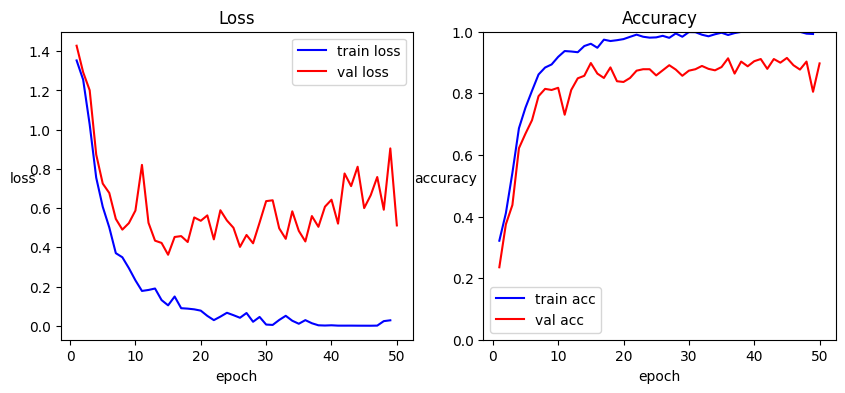

In [54]:
show_result(result)

In [55]:
result.keys()

dict_keys(['train loss', 'val loss', 'train acc', 'val acc', 'val val'])

In [56]:
import json

# 딕셔너리를 JSON 파일로 저장
with open('./Model/vgg16.json', 'w') as f:
    json.dump(result, f)